# Assignment 5 Decision_Tree
### Name: Tanmay Walke
### Date: 24 Feb 2025
### Class: TY-CSE(AI)
### Roll No.: 65

## Import Libraries

In [58]:
import random
import math
import csv
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [59]:
df = pd.read_csv('weather_forecast.csv')

## Data Analysis

In [60]:
df.head()

,Outlook,Temperature,Humidity,Windy,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [61]:
df.tail()

,Outlook,Temperature,Humidity,Windy,Play
9,Rain,Mild,Normal,Weak,Yes
10,Sunny,Mild,Normal,Strong,Yes
11,Overcast,Mild,High,Strong,Yes
12,Overcast,Hot,Normal,Weak,Yes
13,Rain,Mild,High,Strong,No


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Windy        14 non-null     object
 4   Play         14 non-null     object
dtypes: object(5)
memory usage: 692.0+ bytes


In [32]:
#checking for null values
df.isnull().sum()

Outlook        0
Temperature    0
Humidity       0
Windy          0
Play           0
dtype: int64

In [33]:
df.describe()

,Outlook,Temperature,Humidity,Windy,Play
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


In [63]:
rows, cols = df.shape
print(f"Dataset contains {rows} rows and {cols} columns.")

Dataset contains 14 rows and 5 columns.


# Decision Tree

## ID3 Algorithm (without using libraries)

### Building entropy function

In [64]:
# calculate entropy from list of class value
def entropy(values):
    value_count = np.unique(values, return_counts=True)[1]
    value_prob = value_count / float(np.sum(value_count))
    value_prob_log = np.log2(value_prob)
    return -np.dot(value_prob, value_prob_log)

### Node class

In [66]:
class Node:
    def __init__(self,index = [], entropy = 0, depth = 0):
        self.index = index # index of data point
        self.child = [] # list of child
        self.entropy = entropy
        self.depth = depth
        self.attribute = None # attribute use for decision
        self.attribute_value = [] # attribute correspond to each child node
        self.label = None # label if leaf node

In [67]:
x = np.arange(0, 12).reshape(3,-1)
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [69]:
import numpy as np

class ID3Algorithm:
    def __init__(self, samples_cutoff = 2, 
                 min_info_gain = 1e-4, max_depth = 4):
        self.samples_cutoff = samples_cutoff
        self.min_gain = min_info_gain
        self.max_depth = max_depth
        self.root = None
        
    def _entropy(self, index_list):
        if len(index_list) == 0: return 0
        class_value = self.target[index_list]
        entropy_value = entropy(class_value)
        print(f"Entropy for current subset: {entropy_value}")
        return entropy_value
    
    def fit(self, data, target, attributes):
        self.data = data
        self.target = target
        self.attributes = attributes
        self.data_list = np.arange(len(data))
        self.attribute_list = np.arange(len(data[0]))
        self.root = self.build_tree(0, self.data_list, 
                                    entropy=entropy(self.target[self.data_list]),
                                    attribute_list=self.attribute_list,
                                    depth=0)
        
    def build_tree(self, indent, data_index, entropy, attribute_list, depth):
        node = Node(data_index, entropy, depth)
        
        ## check constraint to determine if this node is leaf 
        
        ## 1. data belong to the same class
        value_count = np.unique(self.target[data_index], return_counts=True)[0]
        if len(value_count) == 1:
            node.label = value_count[0][0]
            return node
        
        ## 2. if number of sample < cutoff limit or reach max depth of tree or reach max number of attributes use
        elif len(data_index) < self.samples_cutoff or depth == self.max_depth or len(attribute_list) == 0:
            max_index = np.argmax(value_count[1])
            node.label = value_count[0][max_index]
            return node
        
        ## for each attribute, compute attribute entropy
        attributes_entropy = []
        att_len = len(attribute_list)
        for i in range(att_len): 
            attribute_total_entropy = 0
            attribute_values_count = np.unique(self.data[data_index, attribute_list[i]], return_counts=True)
            attribute_len = len(attribute_values_count[0])
            num_of_data = np.sum(attribute_values_count[1])
            for j in range(attribute_len):
                attribute_value_index = []
                for k in range(len(data_index)):
                    if self.data[data_index[k]][attribute_list[i]] == attribute_values_count[0][j]:
                        attribute_value_index.append(data_index[k])
                attribute_value_entropy = self._entropy(attribute_value_index)
                attribute_total_entropy += attribute_value_entropy * float(attribute_values_count[1][j] / num_of_data)
            
            # Print the entropy for each attribute during computation
            print(f"Attribute {attribute_list[i]} - Entropy: {attribute_total_entropy}")
            attributes_entropy.append(attribute_total_entropy)
        
        # Calculate information gain and print it
        attributes_info_gain = entropy - np.array(attributes_entropy)
        for i in range(len(attributes_info_gain)):
            print(f"Attribute {attribute_list[i]} - Information Gain: {attributes_info_gain[i]}")
        
        attribute_index_with_most_gain = np.argmax(attributes_info_gain)
        attribute_value_with_most_gain = attribute_list[attribute_index_with_most_gain]

        ## 3. the max info gain < min_info_gain
        if attributes_info_gain[attribute_index_with_most_gain] < self.min_gain:
            max_index = np.argmax(value_count[1])
            print(f"Selected label due to min_info_gain: {value_count[0][max_index]}")
            node.label = value_count[0][max_index]
            return node
        
        node.attribute = attribute_value_with_most_gain
        node.attribute_value = np.unique(self.data[data_index, attribute_value_with_most_gain])
        attribute_list_filter = np.delete(attribute_list, attribute_index_with_most_gain)
        
        for i in range(len(node.attribute_value)):
            ## derive new data index list
            new_data_index = []
            for j in range(len(data_index)):
                if self.data[data_index[j]][node.attribute] == node.attribute_value[i]:
                    new_data_index.append(data_index[j])
            
            ## calculate new entropy
            new_entropy = self._entropy(new_data_index)
            new_attribute_list = attribute_list_filter.copy()
            child_node = self.build_tree(indent + 4, new_data_index, new_entropy, new_attribute_list, depth+1)
            node.child.append(child_node)
        
        return node 
    
    def predict(self, new_data):
        npoints = len(new_data)
        labels = [None]*npoints
        for n in range(npoints):
            x = new_data[n] # one point 
            # start from root and recursively travel if not meet a leaf 
            node = self.root
            while node.child: 
                attribute = node.attribute
                idx = 0
                for i in range(len(node.attribute_value)):
                    if x[attribute] == node.attribute_value[i]:
                        idx = i
                        break
                node = node.child[idx]
            labels[n] = node.label

        return labels


### Actual vs True Labels

In [77]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])
for i in range(len(y)):
    if (y[i] == 'Yes'):
        y[i] = 'Y'
    else:
        y[i] = 'N'
attributes = np.array(df.columns[:-1])
attributes
dtm = ID3Algorithm()
dtm.fit(X, y, attributes)
pred = dtm.predict(X)


In [79]:

print("Actual Values:")
print(np.array(pred, dtype='object'))
print("Predicted Values:")
print(y)
#np.unique(pred==y)

Actual Values:
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
Predicted Values:
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']


### Accuracy

In [81]:
# Assuming you have already trained the model and made predictions
pred = dtm.predict(X)

# Calculate accuracy
accuracy = np.mean(pred == y) * 100

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 100.00%


# Random Forest

### With built-in libraries

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = 'weather_forecast.csv'
df = pd.read_csv(file_path)

# Assuming the last column is the target variable and others are features
target_column = df.columns[-1]
X = df.drop(columns=[target_column])
y = df[target_column]

# Convert categorical target variable to binary labels if needed
y = y.map({'Yes': 1, 'No': 0})

# Handle categorical features if present
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, y_test = X, y  # Use the full dataset for testing

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Convert predictions back to Yes/No format
y_pred_labels = ['Yes' if pred == 1 else 'No' for pred in y_pred]
y_test_labels = ['Yes' if actual == 1 else 'No' for actual in y_test]

# Print actual vs predicted values
print("Actual vs Predicted:")
for actual, pred in zip(y_test_labels, y_pred_labels):
    print(f"Actual: {actual}, Predicted: {pred}")


Actual vs Predicted:
Actual: No, Predicted: No
Actual: No, Predicted: No
Actual: Yes, Predicted: Yes
Actual: Yes, Predicted: Yes
Actual: Yes, Predicted: Yes
Actual: No, Predicted: No
Actual: Yes, Predicted: Yes
Actual: No, Predicted: No
Actual: Yes, Predicted: Yes
Actual: Yes, Predicted: Yes
Actual: Yes, Predicted: Yes
Actual: Yes, Predicted: No
Actual: Yes, Predicted: Yes
Actual: No, Predicted: No


In [42]:
# accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)*100
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 92.86%


## Random Forest Without in-built libraries

In [83]:
import numpy as np
import pandas as pd
import random
from collections import Counter
import math


# Load dataset
df = pd.read_csv('weather_forecast.csv')

# Prepare data
target_column = df.columns[-1]
X = df.drop(columns=[target_column]).values
y = df[target_column].map({'Yes': 1, 'No': 0}).values


# Function to calculate entropy of a dataset
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Add small value to avoid log(0)

# Function to calculate information gain
def information_gain(X, y, feature):
    # Calculate entropy of the whole dataset
    entropy_before = entropy(y)
    
    thresholds = np.unique(X[:, feature])
    weighted_entropy_after_split = 0.0
    
    # Calculate entropy after splitting the dataset based on the feature
    for threshold in thresholds:
        X_left, X_right, y_left, y_right = split(X, y, feature, threshold)
        weighted_entropy_after_split += (len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right)
    
    return entropy_before - weighted_entropy_after_split


# Split dataset
def split(X, y, feature, threshold):
    left_mask = X[:, feature] < threshold
    right_mask = ~left_mask
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

# Define Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Build Decision Tree
def build_tree(X, y, depth=0, max_depth=10):
    if len(set(y)) == 1 or depth >= max_depth:
        return Node(value=Counter(y).most_common(1)[0][0])
    
    best_feature, best_threshold, best_gini, best_splits = None, None, float('inf'), None
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = split(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gini_score = (len(y_left) * gini(y_left) + len(y_right) * gini(y_right)) / len(y)
            if gini_score < best_gini:
                best_feature, best_threshold, best_gini, best_splits = feature, threshold, gini_score, (X_left, X_right, y_left, y_right)
    
    if best_feature is None:
        return Node(value=Counter(y).most_common(1)[0][0])
    
    X_left, X_right, y_left, y_right = best_splits
    left_child = build_tree(X_left, y_left, depth + 1, max_depth)
    right_child = build_tree(X_right, y_right, depth + 1, max_depth)
    return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

# Predict using a single tree
def predict_tree(tree, x):
    if tree.value is not None:
        return tree.value
    return predict_tree(tree.left if x[tree.feature] < tree.threshold else tree.right, x)

# Print tree function
def print_tree(tree, depth=0):
    if tree.value is not None:
        print(f"{'  ' * depth}Leaf Node: Class = {tree.value}")
        return
    print(f"{'  ' * depth}Node: Feature {tree.feature}, Threshold = {tree.threshold}")
    print_tree(tree.left, depth + 1)
    print_tree(tree.right, depth + 1)

# Random Forest Classifier
class RandomForestClassifierCustom:
    def __init__(self, n_estimators=10, max_depth=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth)
            self.trees.append(tree)
            print(f"Tree {i+1} Information:")
            print_tree(tree)
            print("\n")
    
    def predict(self, X):
        predictions = np.array([predict_tree(tree, x) for tree in self.trees for x in X]).reshape(self.n_estimators, -1)
        final_predictions = [Counter(predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(final_predictions)


# Train and evaluate model
rf = RandomForestClassifierCustom(n_estimators=3, max_depth=5)
rf.fit(X_train, y_train)

# Printing entropy of target variable
target_entropy = entropy(y)
print(f"Entropy of the target variable: {target_entropy}\n")

# Printing information gain for each feature
for feature in range(X.shape[1]):
    feature_gain = information_gain(X, y, feature)
    print(f"Information Gain for Feature {feature}: {feature_gain}")

# Make predictions
y_pred = rf.predict(X_test)

# Convert predictions to Yes/No format
y_pred_labels = ['Yes' if pred == 1 else 'No' for pred in y_pred]
y_test_labels = ['Yes' if actual == 1 else 'No' for actual in y_test]

# Print actual vs predicted values
print("\nActual vs Predicted:")
for i in range(min(10, len(y_test_labels))):
    print(f"Actual: {y_test_labels[i]}, Predicted: {y_pred_labels[i]}")


Tree 1 Information:
Node: Feature 0, Threshold = Sunny
  Node: Feature 1, Threshold = Mild
    Node: Feature 0, Threshold = Rain
      Leaf Node: Class = 1
      Node: Feature 3, Threshold = Weak
        Leaf Node: Class = 0
        Leaf Node: Class = 1
    Leaf Node: Class = 1
  Leaf Node: Class = 0


Tree 2 Information:
Node: Feature 0, Threshold = Sunny
  Node: Feature 0, Threshold = Rain
    Leaf Node: Class = 1
    Node: Feature 3, Threshold = Weak
      Leaf Node: Class = 0
      Leaf Node: Class = 1
  Node: Feature 1, Threshold = Hot
    Leaf Node: Class = 1
    Leaf Node: Class = 0


Tree 3 Information:
Node: Feature 3, Threshold = Weak
  Leaf Node: Class = 0
  Node: Feature 2, Threshold = Normal
    Node: Feature 0, Threshold = Sunny
      Leaf Node: Class = 1
      Leaf Node: Class = 0
    Leaf Node: Class = 1


Entropy of the target variable: 0.940285955785241

Information Gain for Feature 0: -1.552328103987913
Information Gain for Feature 1: -1.8642760992370682
Information 

In [84]:
# Compute accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Model Accuracy: {accuracy*100:.2f}%")


Model Accuracy: 92.86%


## Confusion Matrix

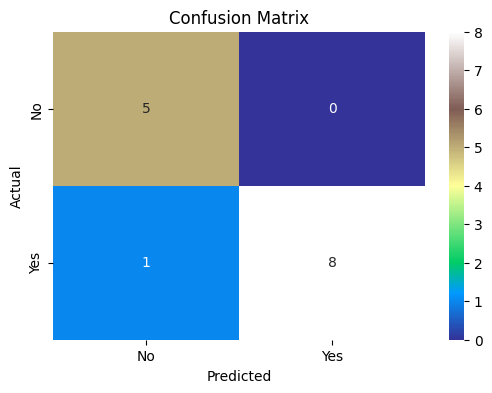

In [85]:
# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = np.zeros((2, 2), dtype=int)
for actual, pred in zip(y_test, y_pred):
    conf_matrix[actual, pred] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='terrain', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Play (Yes or No)

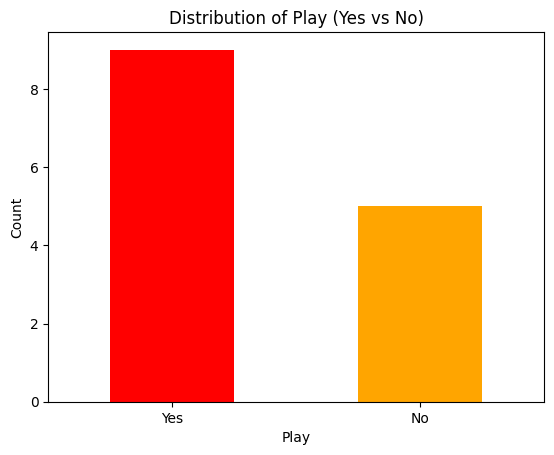

In [46]:
play_counts = df['Play'].value_counts()

# Plotting the distribution
play_counts.plot(kind='bar', color=['Red', 'orange'])
plt.title('Distribution of Play (Yes vs No)')
plt.xlabel('Play')
plt.ylabel('Count')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.show()


In [47]:
table = PrettyTable(["Features", "Distinct Values", "Count"], align="l")

for feature in df.columns[0:-1]:
    unq_vals = df[feature].unique().tolist()
    table.add_row([feature, ", ".join(unq_vals), len(unq_vals)])

print(table)

+-------------+-----------------------+-------+
| Features    | Distinct Values       | Count |
+-------------+-----------------------+-------+
| Outlook     | Sunny, Overcast, Rain | 3     |
| Temperature | Hot, Mild, Cool       | 3     |
| Humidity    | High, Normal          | 2     |
| Windy       | Weak, Strong          | 2     |
+-------------+-----------------------+-------+


In [48]:
df["Play"].value_counts()

Play
Yes    9
No     5
Name: count, dtype: int64

In [49]:
# Filter to fetch all minority class values.
fltr = df["Play"] == "No"

# Apply filter and slice out last four rows.
last_four_rows = df.loc[fltr][-4:]

# Append last four rows of original DataFrame into a new DataFrame.
wthr_dfb = pd.concat([df, last_four_rows], ignore_index=True)

# Sort by `Play` column to check the concatenation.
wthr_dfb.sort_values(by=["Play"], ascending=False)

,Outlook,Temperature,Humidity,Windy,Play
9,Rain,Mild,Normal,Weak,Yes
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
6,Overcast,Cool,Normal,Strong,Yes
8,Sunny,Cool,Normal,Weak,Yes
10,Sunny,Mild,Normal,Strong,Yes
11,Overcast,Mild,High,Strong,Yes
12,Overcast,Hot,Normal,Weak,Yes
13,Rain,Mild,High,Strong,No


In [50]:
# Verify if dataset is balanced.
wthr_dfb["Play"].value_counts()

Play
No     9
Yes    9
Name: count, dtype: int64

In [51]:
X_train = wthr_dfb[["Outlook", "Temperature", "Humidity", "Windy"]]
y_train = wthr_dfb["Play"]

In [52]:
le = LabelEncoder()

X_train = X_train.apply(le.fit_transform)
y_train = le.fit_transform(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (18, 4)
y_train shape: (18,)


In [53]:
clf = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)

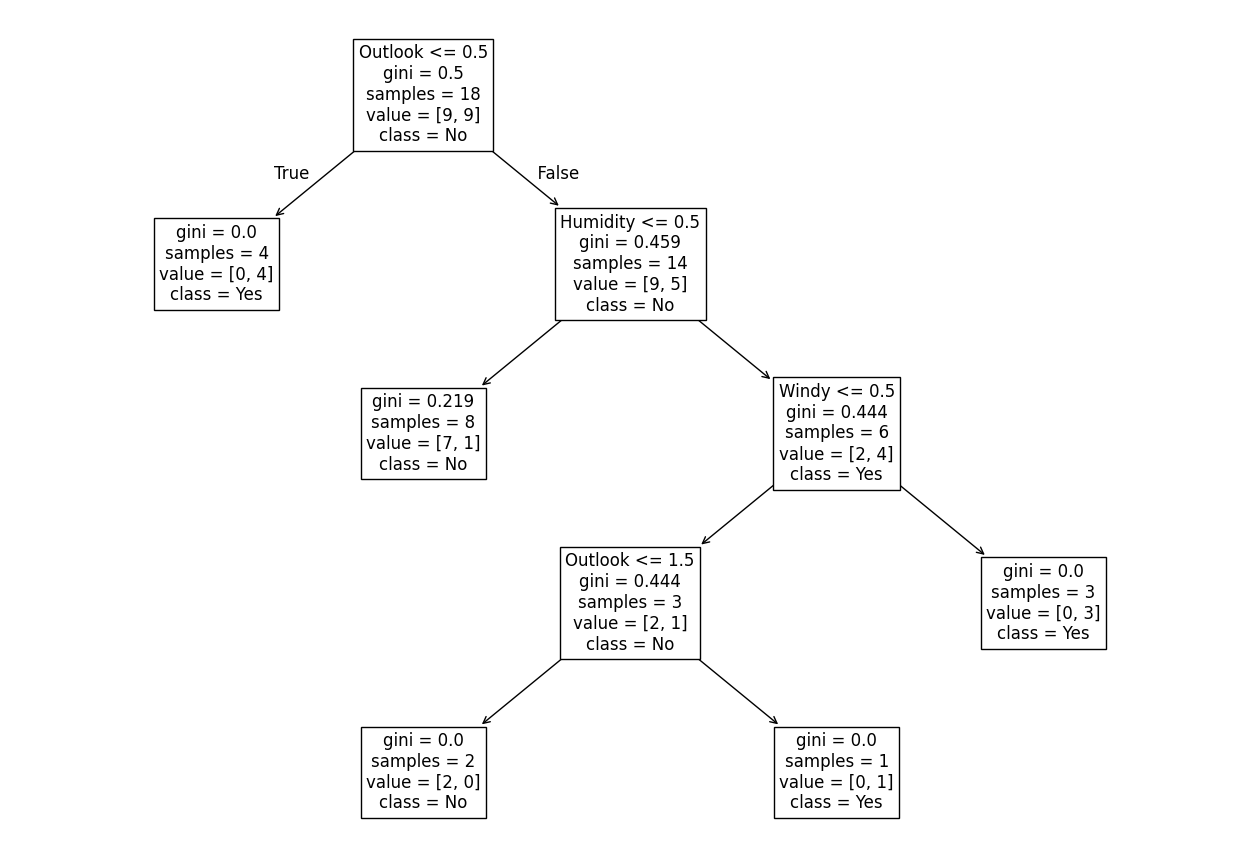

In [54]:
fig = plt.figure(figsize=(16, 11))  # Figsize: Width, Height
tree.plot_tree(clf, feature_names=X_train.columns.tolist(), class_names=["No", "Yes"], fontsize=12)
plt.show()

In [55]:
# Feature importance.
fi = np.around(clf.feature_importances_, 4).tolist()

# Feature names.
ft = X_train.columns.tolist()

table = PrettyTable(["Name", "Importance"], align="l")
table.add_rows(zip(ft, fi))
print(table)

+-------------+------------+
| Name        | Importance |
+-------------+------------+
| Outlook     | 0.5386     |
| Temperature | 0.0        |
| Humidity    | 0.2775     |
| Windy       | 0.1839     |
+-------------+------------+
